# Introduction

This model was created to predict trends in sea level based on data collected in Charleston, South Carolina. The ultimate goal was to attempt to implement a model that could accurately predict the cyclical nature of the data, as well as other trends like the recent increase in sea level rise driven by climate change. 

Due to the presence of long-term dependencies in the time-series data (notably the consistently increasing average sea level), I chose to use an LSTM model for my predictions. This model is a type of recurrent neural network, and its nature was advantageous in this situation since: 
- It can capture long and short-term dependencies (in this case the increase and cyclical nature of the data)
- Overfitting can easily be regulated through hyperparameters like the dropout rate
- It can make accurate predictions for relatively large chunks of new time-series data

In order to accelerate modeling times, the CUDA platform is integrated to make use of the GPU for computation.  

**Sections**
- Imports and Configurations
- Data Preprocessing
    - Null Value Processing
    - Seasonal Decomposition / Analysis
    - Encoding Data
    - Splitting Data
    - Loading Data 
- Model Creation
    - LSTM Model Classes Configuration
    - Configuring Hyperparameters
- Model Training
- Results Analysis
    - Formulating Results
    - Calculating Error Metrics
    - Visualizing Predictions (on Test Data)
    - Future Sea Level Predictions
- Conclusions 
- Sources


# Imports and Configurations

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.preprocessing as prp

from numba import cuda
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from torch.utils.data import TensorDataset, DataLoader

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
PATH = "Resources/charleston_sealevel_1921_2014.csv"

Cuda is implemented to use GPU for model creation/training. Higher-core GPUs permit more efficient computation and faster modeling times. 

- Note: Code is running on a virtual environment with Python 3.8 since CUDA implementation had issues on Python 3.10

In [2]:
cuda.detect()
print(cuda.gpus)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device: ", DEVICE)

Found 1 CUDA devices
id 0    b'NVIDIA GeForce RTX 3050 Laptop GPU'                              [SUPPORTED]
                      Compute Capability: 8.6
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-a139b348-32e2-b243-e8ca-607b8e659f9f
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
<Managed Device 0>
Device:  cuda


# Data Preprocessing

In [3]:
# Data retrieval
data = pd.read_csv(PATH)
data.head()

,time,depth,latitude,longitude,sea_surface_height_above_reference_level,sensor_type_code
0,UTC,m,degrees_north,degrees_east,millimeters,NaN
1,1921-01-01T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
2,1921-01-02T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
3,1921-01-03T12:00:00Z,0.0,32.782,-79.925,NaN,NaN
4,1921-01-04T12:00:00Z,0.0,32.782,-79.925,NaN,NaN


In [4]:
# Crop unneccessary data, ie everything but the numerical time and sea surface height values
data.drop(columns=["depth", "latitude", "longitude", "sensor_type_code"], inplace=True)
data.drop([0], inplace=True)
data.rename(columns={"sea_surface_height_above_reference_level": "sea level"}, inplace=True)
data.head()


,time,sea level
1,1921-01-01T12:00:00Z,NaN
2,1921-01-02T12:00:00Z,NaN
3,1921-01-03T12:00:00Z,NaN
4,1921-01-04T12:00:00Z,NaN
5,1921-01-05T12:00:00Z,NaN


In [5]:
# Inspect and convert data types
print("Initial data types: ")
data.dtypes

Initial data types: 


time         object
sea level    object
dtype: object

In [6]:
data["time"] = pd.to_datetime(data["time"])
data["sea level"] = pd.to_numeric(data["sea level"])
print("New data types: ")
data.dtypes

New data types: 


time         datetime64[ns, UTC]
sea level                float64
dtype: object

**Null Value Processing**

Null values can cause issues with visualization or artificially skew certain observation, so they are eliminated from the dataset. 

In [7]:
# Inspect noticeable null values in dataset
valid_data = (
    pd.DataFrame(data.notna().sum())
        .rename(columns={0: "Valid Entries"})
        .reset_index()
)

nan_data = (
    pd.DataFrame(data.isna().sum())
        .rename(columns={0: "NaN Entries"})
        .reset_index()
)

validity_data = valid_data.merge(nan_data, on='index', how='inner')

validity_data["NaN Percentage"] = (
    validity_data["NaN Entries"]
    /len(data) * 100
)

validity_data["NaN Percentage"] = round(validity_data["NaN Percentage"], 3)

validity_data.head()


,index,Valid Entries,NaN Entries,NaN Percentage
0,time,34333,0,0.000
1,sea level,33529,804,2.342


<Axes: title={'center': 'NaN Value Presence in Sea Level Data'}>

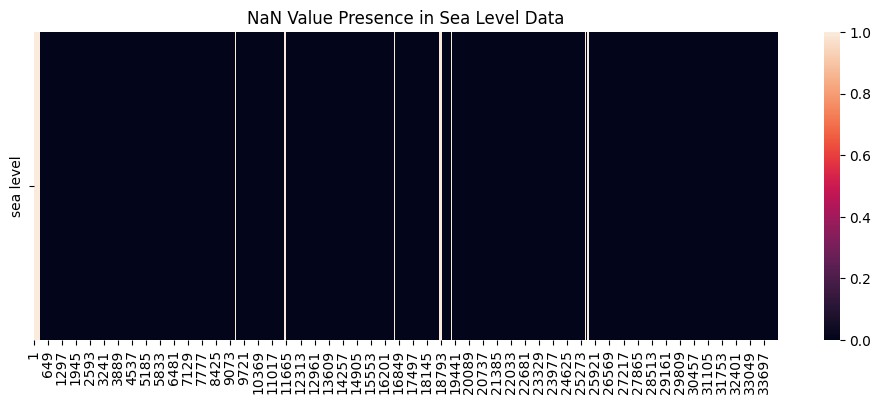

In [8]:
# Visualize location of missing sea level data points
sea_level_data = data[["sea level"]].copy()

plt.figure(figsize=(12, 4))
plt.title("NaN Value Presence in Sea Level Data")

sns.heatmap(sea_level_data.isna().T)


In [9]:
def plot_trendline(df, title, xlabel, ylabel, deg, label="value"): 
    """Plots dataframe with polynomial trendline, returns value change data based on trendline"""
    plt.figure(figsize=(18, 5))

    # Make plot of dataset
    sns.lineplot(x=df.index, y=df.value, label=label)

    # Create trendline
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=deg)
    f = np.poly1d(z)

    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.plot(df.index, f(x), c="#000000", ls="-")

    difference = round(f(len(df)) - f(0), 2)
    return difference
    

Net Sea Level Change: 297.52 mm
Yearly Sea Level Change: 3.17 mm


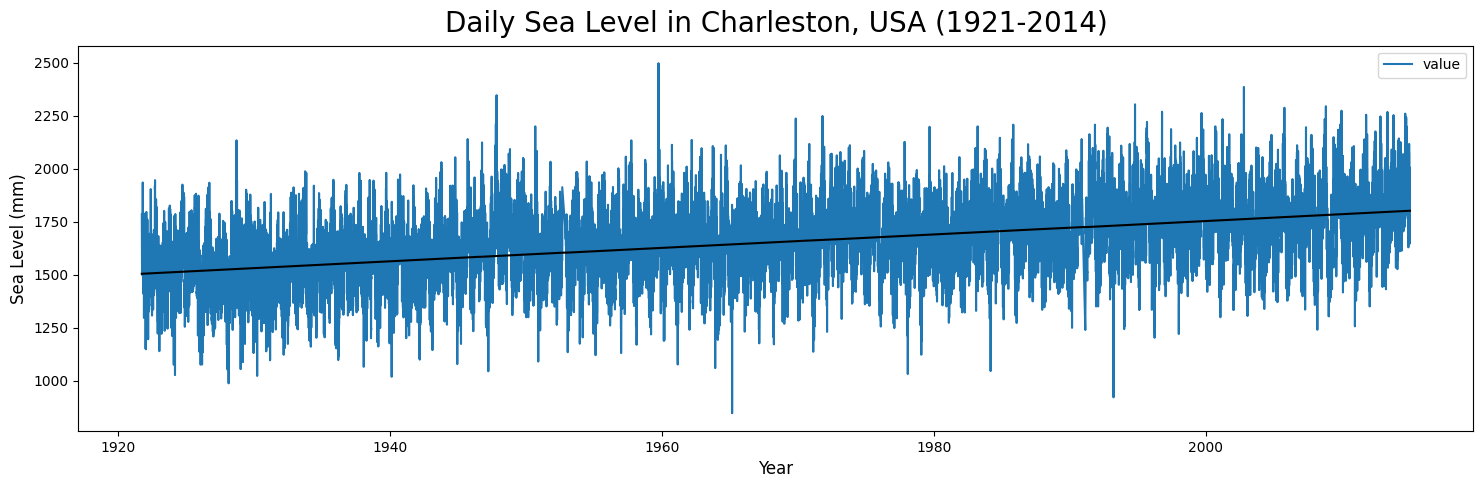

In [10]:
plot_data = data.dropna()
# Convert datetime values to yearly numerical ones
plot_data["year"] = plot_data["time"].dt.year
plot_data = plot_data.set_index(["time"])
plot_data = plot_data.rename(columns={"sea level": "value"})

difference = plot_trendline(plot_data, "Daily Sea Level in Charleston, USA (1921-2014)", 
                            "Year", "Sea Level (mm)", 1)

years = plot_data["year"].unique().size
incr_change = round(difference/years, 2)

print("Net Sea Level Change: {} mm".format(difference))
print("Yearly Sea Level Change: {} mm".format(incr_change))

Net Sea Level Change: 113.29 mm
Yearly Sea Level Change: 8.09 mm


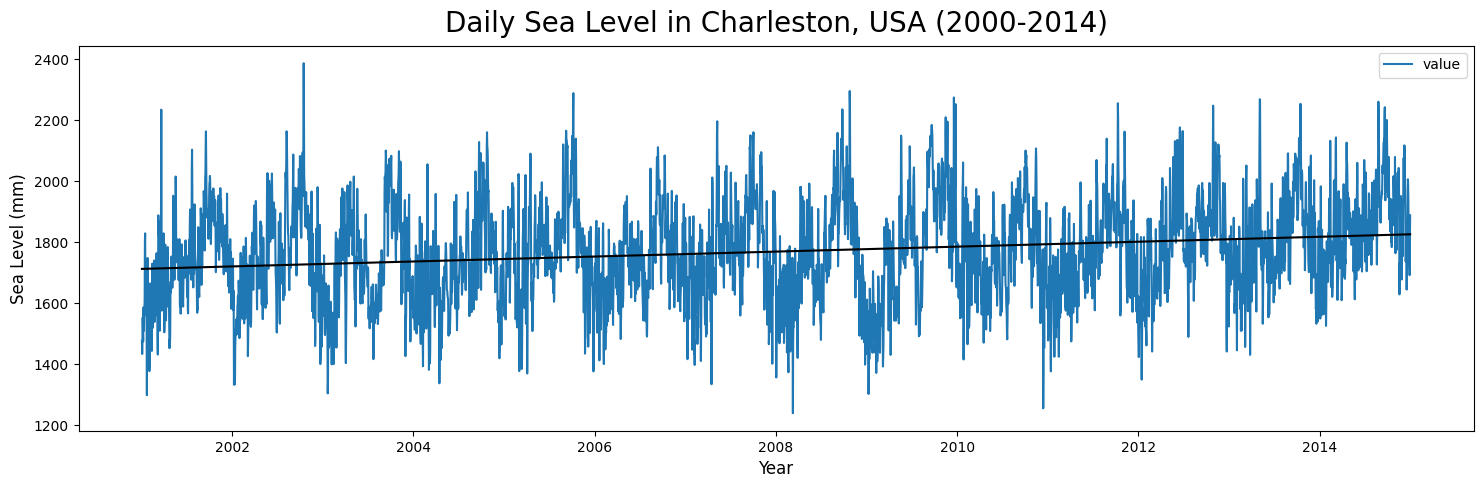

In [11]:
# Plotting smaller subsection of data for trend analysis
recent_plot_data = plot_data[plot_data["year"] > 2000]

difference = plot_trendline(recent_plot_data, 
                            "Daily Sea Level in Charleston, USA (2000-2014)",
                            "Year", "Sea Level (mm)", 1)

years = recent_plot_data["year"].unique().size
incr_change = round(difference/years, 2)

print("Net Sea Level Change: {} mm".format(difference))
print("Yearly Sea Level Change: {} mm".format(incr_change))

**Seasonal Decomposition**

Based on the generated data plots, the sea level seems to behave in a seasonal pattern (ie varies based on the time of the year). Breaking down the data into seasonal components (level, trend, seasonality, noise) can help select appropriate forecasting methods. 

In [12]:
def convert_to_monthly(df): 
    """Converts dataframe to use monthly entries"""
    monthly_data = df.resample("M").mean()
    monthly_data.reset_index(inplace=True)
    monthly_data["time"] = monthly_data["time"].dt.to_period("M")
    monthly_data = monthly_data.set_index("time")
    # Fills NaN values in case some are still present
    monthly_data.interpolate(inplace=True)
    monthly_data.index = monthly_data.index.to_timestamp()
    
    return monthly_data

def plot_seasonal(df, model_type): 
    """Creates seasonal decomposition plot of dataframe"""
    plt.rc("figure", figsize=(14,7))
    result = seasonal_decompose(df["value"], model=model_type)
    result.plot()
    


In [13]:
monthly_lt_data = convert_to_monthly(plot_data)
monthly_st_data = convert_to_monthly(recent_plot_data)

monthly_lt_data.head()

,value,year
time,,
1921-10-01,1669.533333,1921.0
1921-11-01,1573.766667,1921.0
1921-12-01,1533.225806,1921.0
1922-01-01,1421.516129,1922.0
1922-02-01,1478.607143,1922.0


Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Additive Model


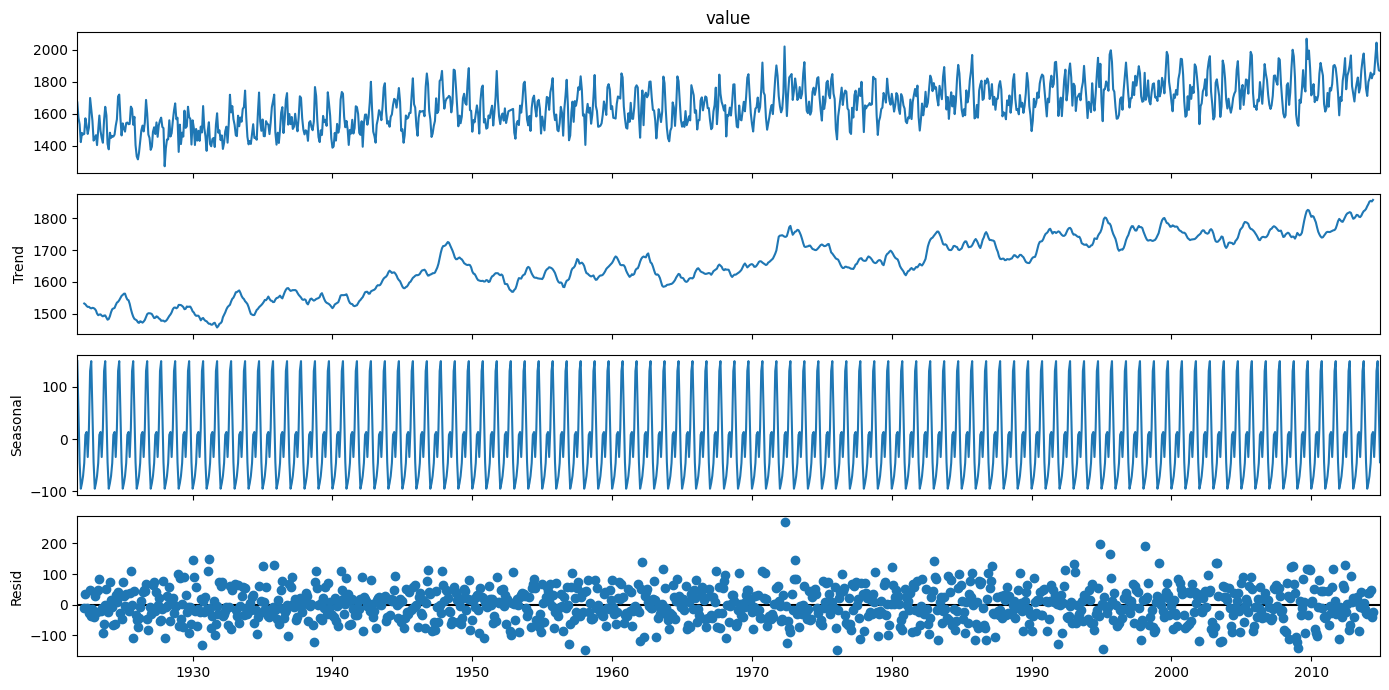

In [14]:
plot_seasonal(monthly_lt_data, "additive")
print("Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Additive Model")

Seasonal Decomposition of Monthly Sea Level (2000 - 2004) - Additive Model


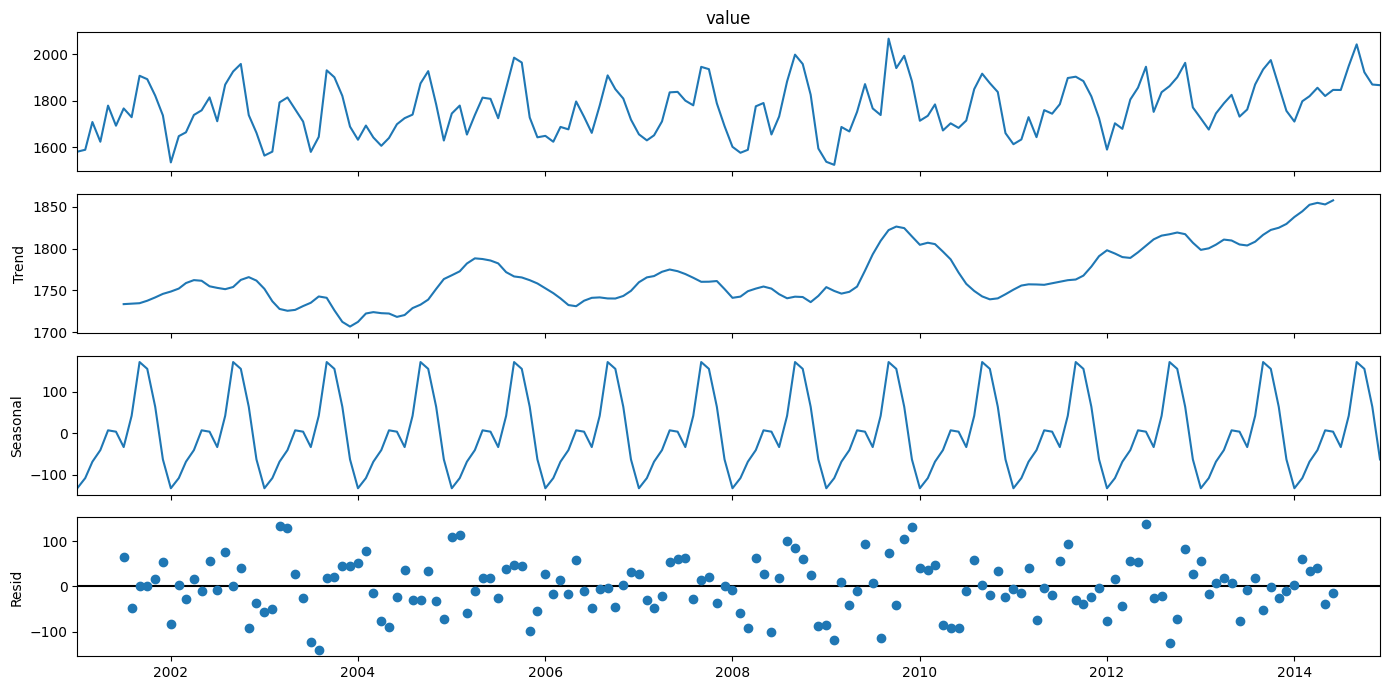

In [15]:
plot_seasonal(monthly_st_data, "additive")
print("Seasonal Decomposition of Monthly Sea Level (2000 - 2004) - Additive Model")

Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Multiplicative Model


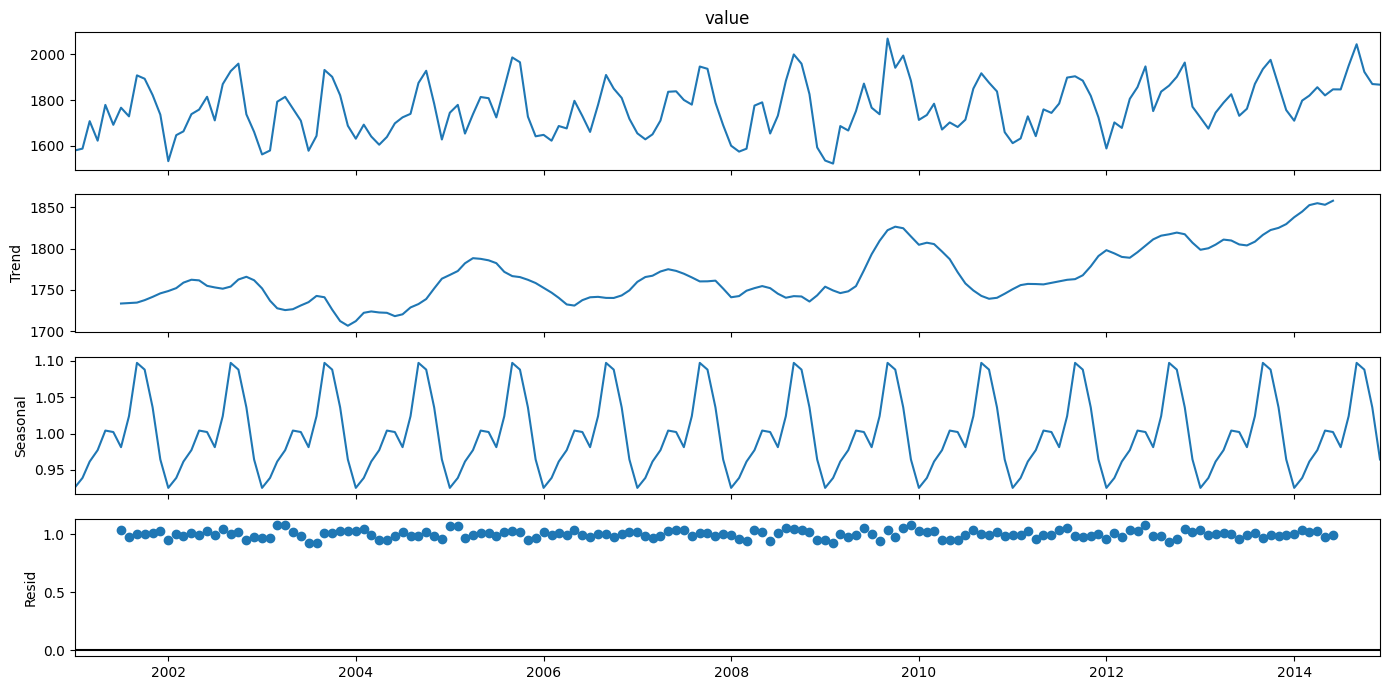

In [16]:
plot_seasonal(monthly_st_data, "multiplicative")
print("Seasonal Decomposition of Monthly Sea Level (1921 - 2004) - Multiplicative Model")

**Seasonal Decomposition - Results Analysis**

Some conclusions can be made based on the result graphs produced above and those produced earlier in the analysis: 
1. The data trends upwards throughout the entire time period, and seems to increase at a faster pace near the end of the dataset (yearly sea level change of +3.17mm/year globally, and of +8.09mm/year for the 10 most recent years)
2. The data varies cyclically every year - seems to reach its lowest point around January of every year and peak around September
3. The data best fits an additive model - Although it trends upwards and cyclically, the residual data is much better fit on the additive seasonal data models than the multiplicative one. 

**Encoding Data**

Due to the presence of invalid values in ~1992 (and earlier), and the change in increase speed seen in the more recent data, the model will be built on data from 2000-2014. To ease modeling cyclic trends, the time data will also be converted into a one-hot encoding. 

In [17]:
# Subset of data from 2000-2014
data["year"] = data["time"].dt.year
model_data = data[data["year"] >= 2000]

model_data = model_data.reset_index()
model_data.drop(columns=["index", "year"], inplace=True)
model_data = model_data.set_index(["time"])
model_data = model_data.rename(columns={"sea level": "value"})
model_data.tail(5)

,value
time,
2014-12-27 12:00:00+00:00,1813.0
2014-12-28 12:00:00+00:00,1752.0
2014-12-29 12:00:00+00:00,1692.0
2014-12-30 12:00:00+00:00,1789.0
2014-12-31 12:00:00+00:00,1888.0


In [18]:
# Convert univariate (time - sea level) series into multivariate (day - week - month - sea level)

data_features = (
    model_data
    .assign(day = model_data.index.day)
    .assign(month = model_data.index.month)
    .assign(year = model_data.index.year)
)

def onehot_encode(df, cols): 
    """Makes a one-hot encoding for select cols in dataframe"""
    for col in cols: 
        indicators = pd.get_dummies(df[col], prefix=col, dtype=int)
        df = pd.concat([df, indicators], axis=1)
    return df

data_features = onehot_encode(data_features, ["day", "month", "year"])

# Set empty cols for predicting future values
data_features["year_2015"], data_features["year_2016"] = 0, 0



In [19]:
def generate_cyclical_features(df, col_name, period, start_num=0): 
    """Generates sin and cos features for time increments"""
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)
    }

    return df.assign(**kwargs).drop(columns=[col_name])

data_features = generate_cyclical_features(data_features, "day", 31, 1)
data_features = generate_cyclical_features(data_features, "month", 12, 1)


**Splitting Data**

The data will now be split into 3 subsets: 
- Training data: A majority of the time series used for training the model. The data at the end of the series is left out (to eventually be tested on).
- Validation data: A small subsection of the end of the training data series. Used to analyse and tune the hyperparameters that configure the model.
- Testing data: The end of the time series not used in the training/validation set. Used to test the performance of the model on "new" data it has not seen. 

The data will also be scaled to fit a fixed range [0, 1] to normalize high values. A MinMax transformation will be calculated and applied through scikit's fit() and transform() functions, respectively. 

In [20]:
def split_feature(df, col): 
    """Extracts a specific column from dataframe"""
    col_df = df[[col]]
    no_col_df = df.drop(columns=[col])
    return no_col_df, col_df


def split_data(df, target_col, test_ratio): 
    """Splits a df's data into train, validation and test data. Target data should be inputted as target_col"""
    validation_ratio = test_ratio / (1 - test_ratio)
    x, y = split_feature(df, target_col)
    # Shuffling omitted to maintain time series validity
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, shuffle=False)
    _,  x_val, _, y_val = train_test_split(x_train, y_train, test_size=validation_ratio, shuffle=False)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = split_data(data_features, "value", 0.2)
print("""New Data Dimensions (rows, columns) : 
      Training data: x - {}, y - {}
      Validation data: x - {}, y - {}
      Testing data: x - {}, y - {}"""
      .format(x_train.shape, y_train.shape, 
              x_val.shape, y_val.shape, 
              x_test.shape, y_test.shape))


New Data Dimensions (rows, columns) : 
      Training data: x - (4383, 65), y - (4383, 1)
      Validation data: x - (1096, 65), y - (1096, 1)
      Testing data: x - (1096, 65), y - (1096, 1)


In [21]:
# Convert dataframes to scaled Numpy arrays
x_scaler = prp.MinMaxScaler()
y_scaler = prp.MinMaxScaler()
# Predictors
scaled_x_train = x_scaler.fit_transform(x_train)
# Transforms validation and test data under the same fit params as training data
scaled_x_val = x_scaler.transform(x_val)
scaled_x_test = x_scaler.transform(x_test)

# Target vars
scaled_y_train = y_scaler.fit_transform(y_train)
scaled_y_val = y_scaler.transform(y_val)
scaled_y_test = y_scaler.transform(y_test)

print(scaled_x_train)

[[0.         1.         0.         ... 1.         0.5        1.        ]
 [0.         0.         1.         ... 0.98973865 0.5        1.        ]
 [0.         0.         0.         ... 0.95937469 0.5        1.        ]
 ...
 [1.         0.         0.         ... 0.91015123 0.25       0.9330127 ]
 [1.         0.         0.         ... 0.95937469 0.25       0.9330127 ]
 [1.         0.         0.         ... 0.98973865 0.25       0.9330127 ]]


**Loading Data**

Data must be split into batches to train the RNN model, which can be done with the Pytorch.DataLoader class. The whole process involves: 
1. Convert data to tensors (multi-dimensional matrices)
2. Wrap the tensors into datasets (divided by train, validation and test)
3. Convert datasets to DataLoaders (where params like "shuffle" are specified)

In [22]:
# Define nb. of entries to train at a time (kept as power of 2 to maximize GPU processing, multiple values tested)
BATCH_SIZE = 32

# Convert data to tensors
train_features = torch.Tensor(scaled_x_train)
train_targets = torch.Tensor(scaled_y_train)
val_features = torch.Tensor(scaled_x_val)
val_targets = torch.Tensor(scaled_y_val)
test_features = torch.Tensor(scaled_x_test)
test_targets = torch.Tensor(scaled_y_test)

# Convert tensors to datasets
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Convert datasets to DataLoaders
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


# Model Creation

**LSTM Model Classes Creation**

Classes will be defined to facilitate the creation and training processes of the model. The LSTMModel class will help define and tune hyperparameters for the model, while the Optimizer class will help with (fill in).

Source for LSTMModel class implementation: https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

Source for Optimizer class implementation: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [23]:
class LSTMModel(nn.Module): 
    """
    Class inheriting nn.Module intended to define features and behaviour of LSTM model. 
    -- Input params (in __init__ method) --
    - input_dim (int): Number of nodes in input layer
    - hidden_dim (int): Number of nodes per layer
    - layer_dim (int): Number of layers in network
    - output_dim (int): Number of nodes in output layer
    - dropout_prob (float): Probability of nodes being dropped out
    """

    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 layer_dim, 
                 output_dim, 
                 dropout_prob): 
        """Static values init"""
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM creation
        self.lstm = nn.LSTM(input_dim, 
                            hidden_dim, 
                            layer_dim, 
                            batch_first=True, 
                            dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, tensor): 
        """
        Forward propagation for input tensor. Returns output tensor of the shape.
        """
        # Hidden and cell states for first input are zero
        h0 = torch.zeros(self.layer_dim, tensor.size(0), self.hidden_dim, device=tensor.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, tensor.size(0), self.hidden_dim, device=tensor.device).requires_grad_()

        # Backpropagation through time requires detaching to avoid backproping all the way to the start
        out, (hn, cn) = self.lstm(tensor, (h0.detach(), c0.detach()))

        # Reshaping outputs in the shape of (batch_size, seq_length, hidden_size) to fit into fully connected layer
        out = out[:, -1, :]

        # Conversion to desired output shape
        out = self.fc(out)
        
        return out



class Optimization:
    """
    Optimization is a helper class used to train and validate models, and to predict their future values. 
    Its inputs are a model, loss function, optimizer function, and optionally early stopping and learning scheduler. 
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """
        Completes one step of the training given a feature value tensor (x) and a target value tensor. 
        - Activates train mode to enable back propagation
        - Calculates losses by using loss function
        - Computes gradients by doing back propagation
        - Updates weights by calling step() function
        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, 
              train_loader, 
              val_loader, 
              batch_size=64, 
              n_epochs=50, 
              n_features=1):
        """
        Trains DataLoaders (of training and validation datasets) based on args. This is done by iteratively calling 
        the method train_step for (n_epochs) times. Model is then saved to a designated location. 
        If GPU available, uses it to increase computing capacity for faster execution. 

        --Arguments--
            train_loader: torch.utils.data.DataLoader
                DataLoader that stores training data
            val_loader: torch.utils.data.DataLoader
                DataLoader that stores validation data
            batch_size: int
                Batch size for mini-batch training
            n_epochs: int 
                Number of epochs, i.e., train steps, to train
            n_features: int
                Number of feature columns

        """
        model_path = f'model_lstm'
        
        for epoch in range(1, n_epochs + 1):
            # mini-batch training iteration of training datasets
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
                # update training loss value
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                # mini-batch training iteration of validation datasets
                batch_val_losses = []
                validation = []
                validation_values = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(DEVICE)
                    y_val = y_val.to(DEVICE)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                    #
                    yhat = yhat.cpu().data.numpy()
                    y_val = y_val.cpu().data.numpy()
                    validation.append(yhat)
                    validation_values.append(y_val)
                # update validation loss value
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
            
            # print loss value per epoch period
            if (epoch <= 10) | (epoch % 10 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
        return validation, validation_values

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model
            values: list[float]
                The actual values in the test set.

        """
        # mini-batch testing to evaluate data from test dataset
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(DEVICE)
                y_test = y_test.to(DEVICE)
                self.model.eval()
                yhat = self.model(x_test)
                yhat = yhat.cpu().data.numpy()
                # save model prediction result to list
                predictions.append(yhat)
                y_test = y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values

    def predict(self, future_loader, batch_size=1, n_features=1):
        """
        The method takes DataLoaders for the predicting future dataset, batch size for mini-batch testing,
        and number of features as inputs. 

        --Arguments--
            test_loader: torch.utils.data.DataLoader 
                DataLoader that stores test data
            batch_size: int
                Batch size for mini-batch training
            n_features: int
                Number of feature columns

        --Returns--
            predictions: list[float]
                The values predicted by the model

        """
        # mini-batch testing to predict data from future dataset
        with torch.no_grad():
            predictions = []
            for x_test in test_dl:
                x_test = x_test.view([batch_size, -1, n_features]).to(DEVICE)
                self.model.eval()
                yhat = self.model(x_test)
                # save model prediction result to list
                yhat = yhat.cpu().data.numpy()
                predictions.append(yhat)

        return predictions
    
    def plot_losses(self):
        """
        The method plots the calculated loss values for training and validation
        """
        plt.figure(figsize=[8, 5])
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

**Configuring Hyperparameters**

The model can be fine-tuned with different hyperarameter values. Based on our LSTMModel and Optimizer class, there are a few that can be configured for the model: 
- Input dimension: Number of features (predictors) being fed into the model
- Output dimension: Number of values being output as a prediction
- Hidden dimension: Number of features in the hidden state
- Layer dimension: The number of stacked LSTM layers
- Batch size: Number of samples that propagage through the network before model parameters are updated
- Dropout rate: Amount of nodes kept for input in a layer (ie for a dropout rate of 0.2, 1/5th of nodes are ignored (chosen randomly))
- Number of epochs: Number of times the algorithm will work through the dataset. The model was configured with a high number of epochs to produce outputs that match the volatility of the dataset. 
- Learning rate: Controls how much to change the model in response to estimated error each time the model weights are updated. 
- Weight decay: Regularization technique used to control overfitting

In [24]:
# Hyperparameter config
input_dim = len(x_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 4
batch_size = BATCH_SIZE
dropout = 0.1
n_epochs = 256
learning_rate = 0.001
weight_decay = 1e-6

# Create dictionary of configs
model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}


# Model Training

[1/256] Training loss: 0.0735	 Validation loss: 0.0189
[2/256] Training loss: 0.0163	 Validation loss: 0.0171
[3/256] Training loss: 0.0144	 Validation loss: 0.0192
[4/256] Training loss: 0.0144	 Validation loss: 0.0165
[5/256] Training loss: 0.0141	 Validation loss: 0.0146
[6/256] Training loss: 0.0139	 Validation loss: 0.0152
[7/256] Training loss: 0.0139	 Validation loss: 0.0161
[8/256] Training loss: 0.0138	 Validation loss: 0.0164
[9/256] Training loss: 0.0136	 Validation loss: 0.0174
[10/256] Training loss: 0.0135	 Validation loss: 0.0195
[20/256] Training loss: 0.0136	 Validation loss: 0.0251
[30/256] Training loss: 0.0113	 Validation loss: 0.0108
[40/256] Training loss: 0.0111	 Validation loss: 0.0196
[50/256] Training loss: 0.0113	 Validation loss: 0.0199
[60/256] Training loss: 0.0095	 Validation loss: 0.0083
[70/256] Training loss: 0.0093	 Validation loss: 0.0113
[80/256] Training loss: 0.0096	 Validation loss: 0.0154
[90/256] Training loss: 0.0085	 Validation loss: 0.0091
[

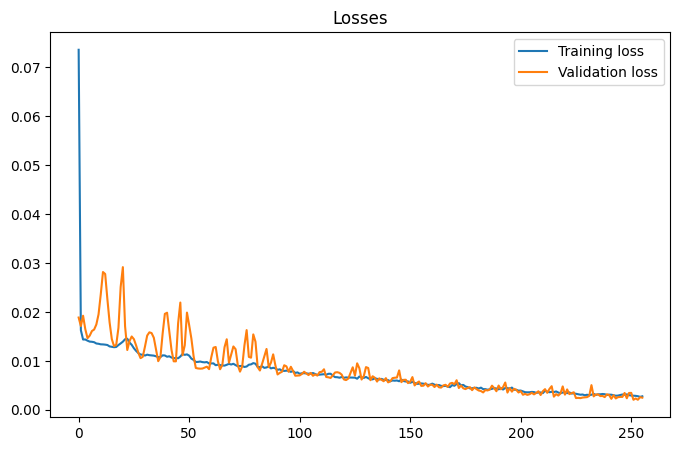

Execution time with cuda: 97.55s


In [25]:
start_time = time.perf_counter()

model = LSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model.to(DEVICE), loss_fn=loss_fn, optimizer=optimizer)
validation, validation_values = opt.train(
    train_dl, 
    val_dl, 
    batch_size=batch_size,
    n_epochs=n_epochs,
    n_features=input_dim   
)

opt.plot_losses()

# Evaluate model based on model from training dataset
predictions, values = opt.evaluate(
    test_dl,
    batch_size=batch_size,
    n_features=input_dim
)

total_time = time.perf_counter() - start_time
print("Execution time with {}: {}s".format(DEVICE, round(total_time, 2)))

# Results Analysis

**Formatting the Results**

The data will need to be reconverted from its scaled form to allow visualization and analysis. 

In [26]:
# Inverse the scale from model results
def inverse_transform(scaler, df, cols): 
    for col in cols: 
        df[col] = scaler.inverse_transform(df[col])
    return df

# Flatten multi-dimensional tensors to a single dimension
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

In [27]:
df_val = format_predictions(validation, validation_values, x_val, y_scaler)
df_result = format_predictions(predictions, values, x_test, y_scaler)
df_result.head()

,value,prediction
time,,
2012-01-01 12:00:00+00:00,1474.0,1616.205444
2012-01-02 12:00:00+00:00,1424.0,1572.087524
2012-01-03 12:00:00+00:00,1430.0,1614.164551
2012-01-04 12:00:00+00:00,1568.0,1644.010864
2012-01-05 12:00:00+00:00,1562.0,1630.091675


**Calculating Error Metrics**

A few error metrics will be used to quantify the accuracy of the model. The Mean Absolute Error refers simply to the average error margin for each of the predictions made on the test set. The Root Mean Squared Error also measures an average difference between the predicted values and the actual ones. Since the model deals with larger-scale data, these two values are expected to be high. The Mean Absolute Percentage Error describes the error for each prediction on the basis of percentage, and will therefore have a lower value. The MAPE is not affected by the scale of the data predicted, and is therefore a better measure of the general accuracy of the model. 

In [28]:
def calculate_metrics(df):
    result_metrics = {'mae' : round(mean_absolute_error(df.value, df.prediction), 4),
                      'rmse' : round(np.sqrt(mean_squared_error(df.value, df.prediction)), 4),
                       'mape' : round(mean_absolute_percentage_error(df.value, df.prediction), 4)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("MAPE Score:                ", result_metrics["mape"])
    
    return result_metrics

result_metrics = calculate_metrics(df_result)

Mean Absolute Error:        127.3853
Root Mean Squared Error:    163.083
MAPE Score:                 0.0681


**Visualizing predictions**

The model can first be analysed by its performance on the training set (of which the error metrics were also measured). 

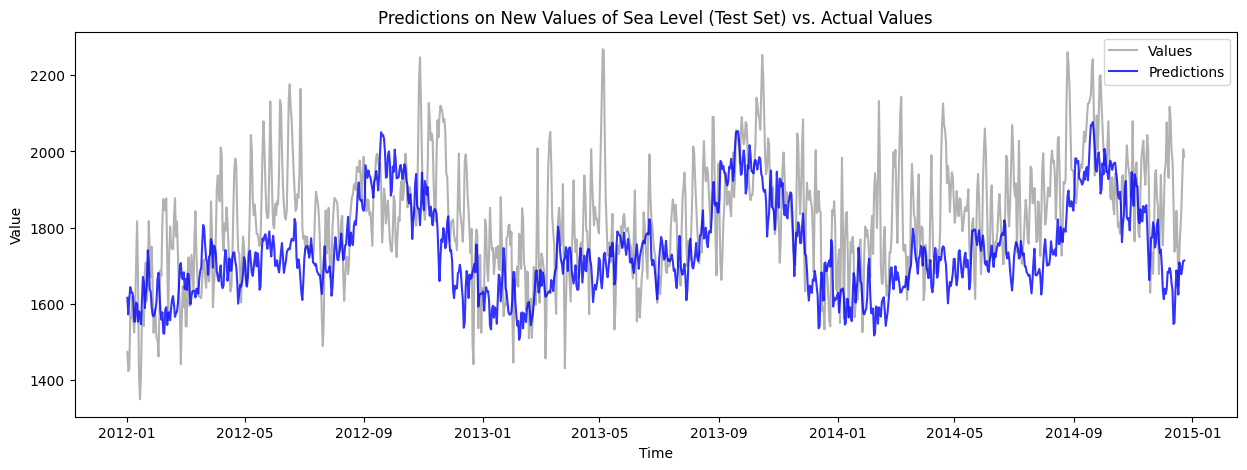

In [29]:
def plot_predictions(df_result):
    plt.figure(figsize=(15,5))
    value = sns.lineplot(x = df_result.index, y=df_result.value, color='k', alpha = 0.3, label = "Values")
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='b',alpha = 0.8, label = "Predictions")
    
    plt.title("Predictions on New Values of Sea Level (Test Set) vs. Actual Values")
    plt.xlabel('Time')
    plt.ylabel('Value') 
    
plot_predictions(df_result)

The model's prediction of sea level increase can also be observed. Since this increase is more significant in the later cycles of the series, it is challenging to obtain predictions that match it exactly. 

Sea level rise (values) from 2012-2014: 149.33 mm
Sea level rise (prediction) from 2012-2014: 84.19 mm


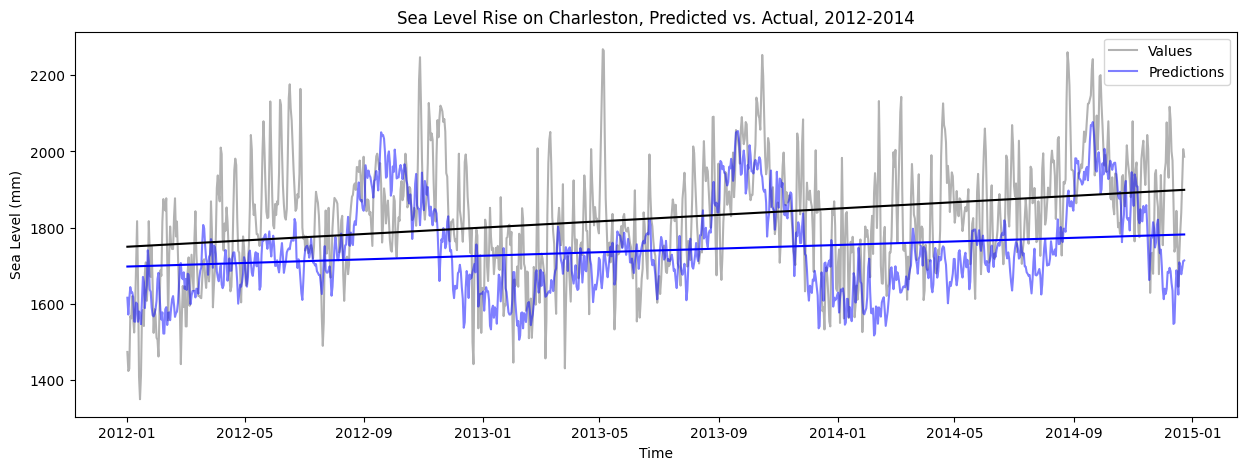

In [30]:
def plot_dataset_trendline_after_model(df, title):
    plt.figure(figsize=(15, 5))
    # plot dataset
    sns.lineplot(x=df.index, y=df.value, color = 'k', alpha = 0.3, label="Values")
    sns.lineplot(x=df.index, y=df.prediction, color='b', alpha= 0.5, label="Predictions")

    # plot trendline of observation value
    x = range(0, len(df))
    z = np.polyfit(x, y=df.value, deg=1)  
    f = np.poly1d(z)
    plt.plot(df.index, f(x), c="k", ls='-')
    print(f'Sea level rise (values) from 2012-2014: {round(f(len(df)) - f(0), 2)} mm')
    
    # plot trendline of prediction (have to be clean from missing data)
    x = range(0, len(df))
    z = np.polyfit(x, y=df.prediction, deg=1)  
    f = np.poly1d(z)
    plt.plot(df.index, f(x), c="b", ls='-')
    print(f'Sea level rise (prediction) from 2012-2014: {round(f(len(df)) - f(0), 2)} mm')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)')
    
plot_dataset_trendline_after_model(df_result, 'Sea Level Rise on Charleston, Predicted vs. Actual, 2012-2014')

**Future Sea Level Prediction**

The model can also be used to make predictions on "future" (relative to dataset) values. 

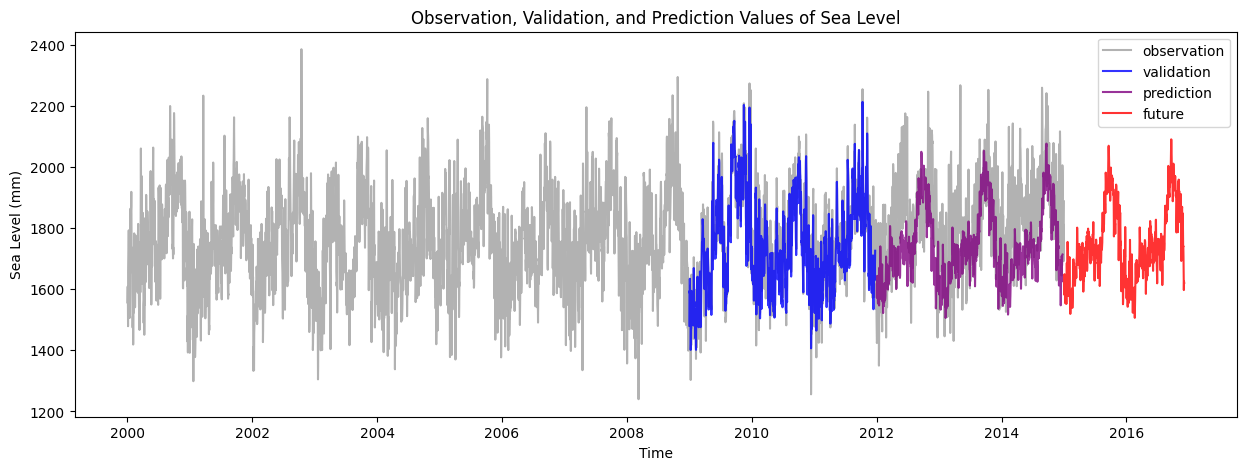

In [31]:
def give_year_name(df, start, end, name):
    i = start
    while i <= end:
        df[f'{name}_{i}'] = 0
        i += 1
    
    return df
from datetime import date

def plot_all(df_result, df_train, df_val):
    plt.figure(figsize=(15,5))
    observation = sns.lineplot(x = df_train.index, y=df_train.value, color='k', alpha = 0.3, label = 'observation')
    validation = sns.lineplot(x = df_val.index, y=df_val.prediction, color='b', alpha = 0.8, label = 'validation')
    prediction = sns.lineplot(x = df_result.index, y=df_result.prediction, color='#800080', alpha = 0.8, label = 'prediction')
    
    plt.title("Observation, Validation, and Prediction Values of Sea Level")
    plt.xlabel('Time')
    plt.ylabel('Sea Level (mm)') 

sdate = date(2015,1,1)   # define start date
edate = date(2016,12,31)   # define end date

# make a dataframe with range of sdate and edate
df_future = pd.DataFrame(pd.date_range(sdate, edate, freq='d'))
df_future.columns = ['time']
df_future['value'] = 0 # it's just here because the function need it as an input
df_future.set_index('time', inplace=True)

# make features with datetime object
df_future = (df_future
             .assign(day = df_future.index.day)
             .assign(month = df_future.index.month)
             .assign(year = df_future.index.year)
            )

# one hot encoding the features
df_future = onehot_encode(df_future, ['day', 'month'])
df_future = give_year_name(df_future, 2000, 2014, 'year')
df_future = onehot_encode(df_future, ['year'])

df_future = generate_cyclical_features(df_future, 'day', 31, 1)
df_future = generate_cyclical_features(df_future, 'month', 12, 1)
# split the data that we going to predict
x_fut, y_fut = split_feature(df_future, 'value')

#scaling
x_scaler = prp.MinMaxScaler()
y_scaler = prp.MinMaxScaler()
scaled_x_train = x_scaler.fit_transform(x_train)
scaled_x_fut = x_scaler.transform(x_fut)
# X_fut_arr = np.array(X_fut)
scaled_y_train = y_scaler.fit_transform(y_train)
scaled_y_fut = y_scaler.transform(y_fut)

# convert to tensor
X_fut_tens = torch.Tensor(scaled_x_fut)
y_fut_tens = torch.Tensor(scaled_y_fut)

# convert to Dataset object (pytorch)
future = TensorDataset(X_fut_tens, y_fut_tens)
future_loader = DataLoader(future, batch_size=batch_size, shuffle=False, drop_last=True)
# predict using evaluate function
fut_predictions, fut_values = opt.evaluate(
    future_loader,
    batch_size=batch_size,
    n_features=input_dim
)

# format the prediction result
df_future_predict = format_predictions(fut_predictions, fut_values, x_fut, y_scaler)
def plot_future(df_result, df_train, df_val, df_future):
    plot_all(df_result, df_train, df_val)

    future = sns.lineplot(x = df_future.index, y=df_future.prediction, color='r', alpha = 0.8, label = 'future')
    
plot_future(df_result, data_features, df_val, df_future_predict)

# Conclusions
- We were able to create a LSTM model that accurately portrays the cyclical sea level patterns seen in the data. 
- The model was able to identify some non-cyclical trends in the data (like an increase in average sea level)
- We achieved relatively strong accuracy measures - The model had a RMSE value of 0.068 on "new" data.
- Implementing GPU-based processing significantly improved the training speed of our model - With a training time of 198.89s using the CPU and 97.55s using the CPU, we achieved a 51.0% reduction in modeling time.  

# Sources

https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

https://www.kaggle.com/code/kevinwibowo/sea-level-rise-prediction-with-pytorch

https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/

